# DBL Process Mining

## Imports and Class definitions

### Imports

In [38]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
from Utils.LogFile import LogFile 
import tensorflow as tf
import multiprocessing as mp
import copy
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
import seaborn as sns


## Loading in the data

### Two different methods: 
- One csv file, which still has to be split into training and test data
- Two csv files, which are already split into training and test data

In [39]:
# Define attribute columns here
case_attr = "Case ID"
act_attr = "concept:name"
time_attr = "Complete Timestamp"
path = "data/BPI_Challenge_2012_end.csv"
time_format = '%Y-%m-%d %H:%M:%S.%f'


In [40]:

logfile = LogFile(path, ",", 0, None, time_attr=time_attr, trace_attr=case_attr,
                   activity_attr=act_attr, time_format=time_format, convert=False, k=3)
logfile = logfile.create_subset(40)


## Visualization

In [23]:
split_log = logfile.create_split_df()
split_train, split_test = split_log.split_train_test(range(67, 73), type='normal')

Train data lost due to overlap: 0.04417617405147254/n Best Split: 68


c:\Users\20204502\OneDrive - TU Eindhoven\Documents\GitHub\Process-Mining\Process-Mining\Utils\LogFile.py:378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_data[self.time] = pd.to_datetime(split_data[self.time])


In [24]:
split_date = split_train.data['Complete Timestamp'].max()
split_case = split_train.data['Case ID'].max()

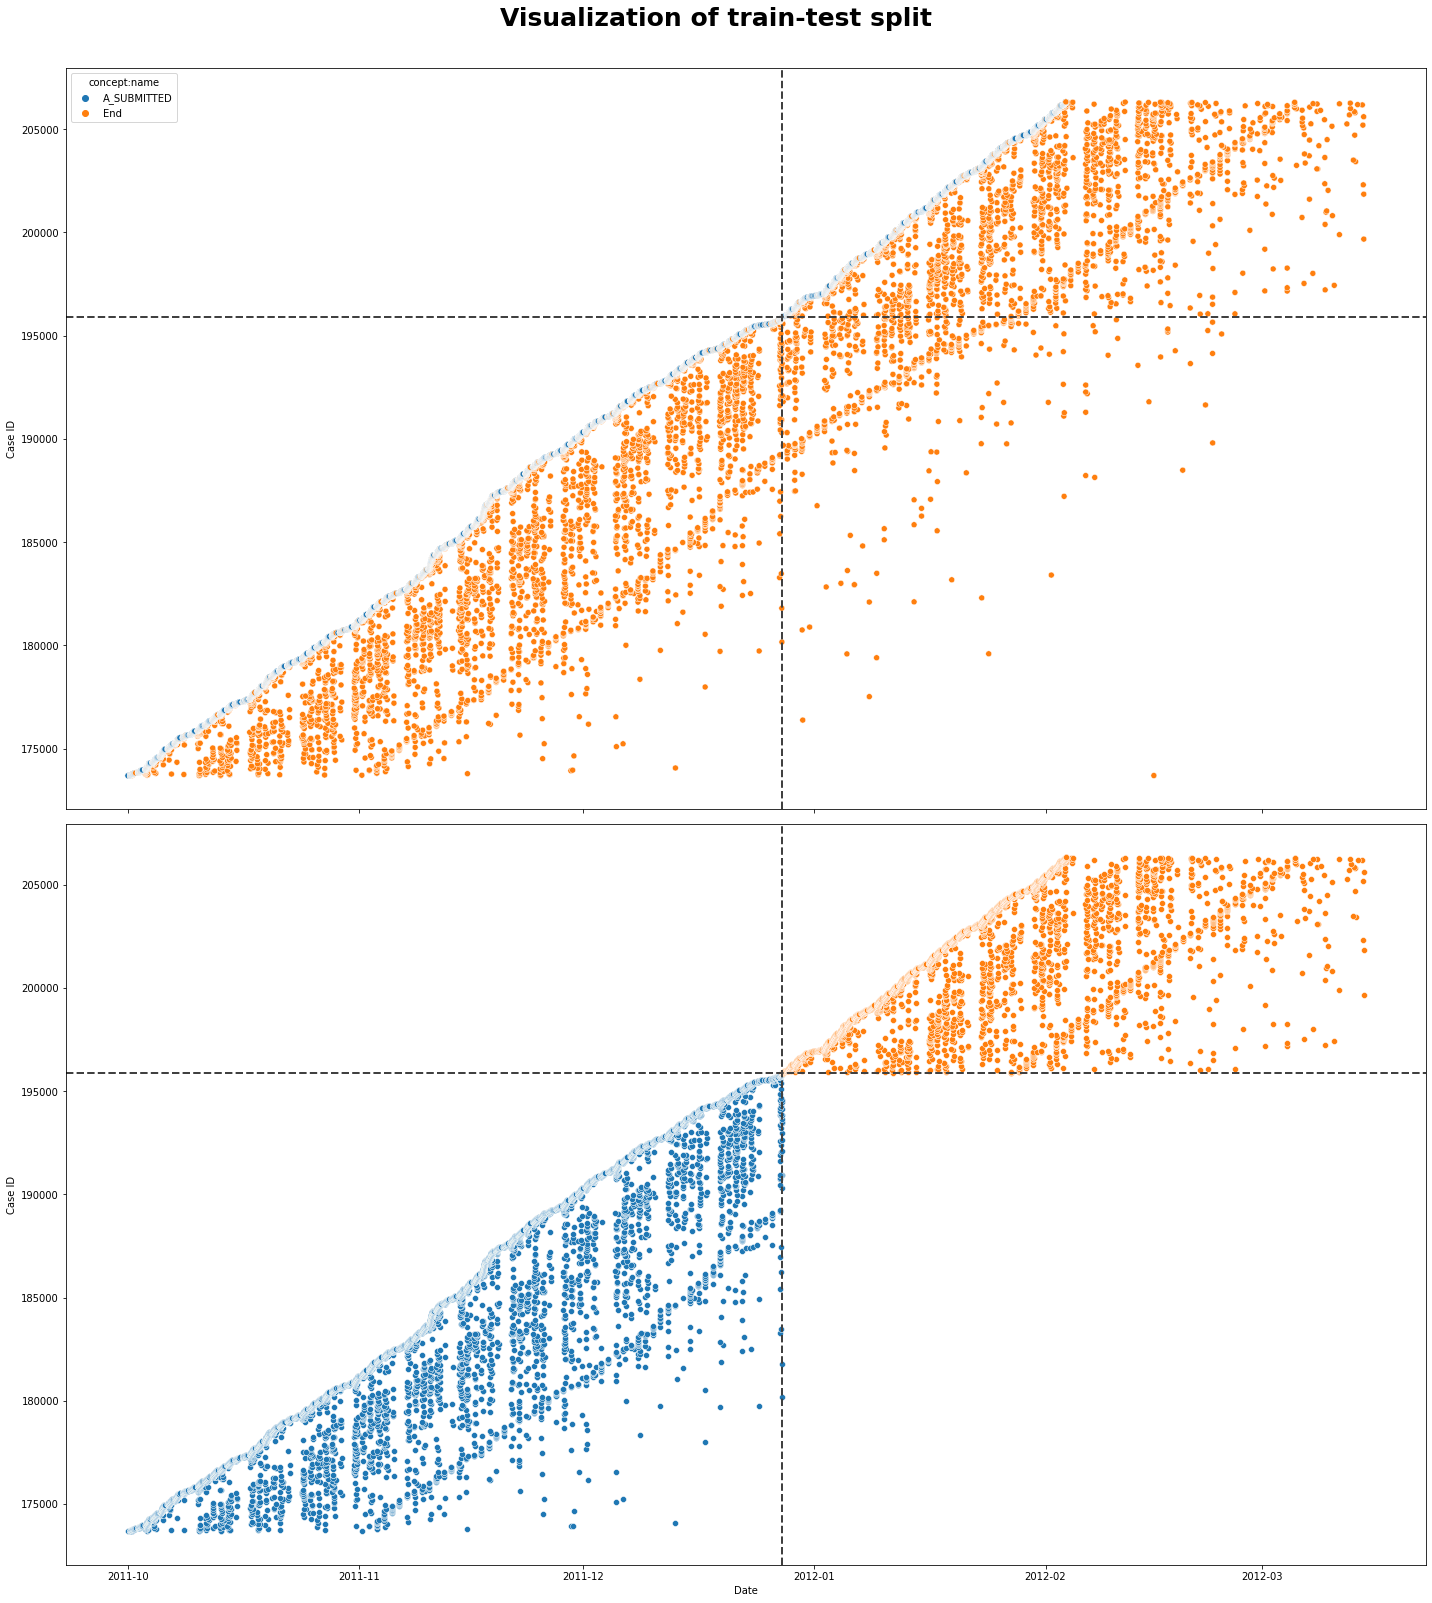

In [25]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 22))

sns.scatterplot(data=split_log.data, x=split_log.time, y=split_log.trace, hue=split_log.activity, ax=ax[0])
sns.scatterplot(data=split_train.data, x=split_log.time, y=split_log.trace, ax=ax[1])
sns.scatterplot(data=split_test.data, x=split_log.time, y=split_log.trace, ax=ax[1])

fig.suptitle('Visualization of train-test split', size=25, weight='bold', y=1.01)
fig.tight_layout()

ax[0].set_xlabel('')
ax[0].set_ylabel('Case ID')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Case ID')

ax[0].axvline(x=split_date, color = '#404040', linestyle='--', linewidth=2)
ax[0].axhline(y=split_case, color = '#404040', linestyle='--', linewidth=2)
ax[1].axvline(x=split_date, color = '#404040', linestyle='--', linewidth=2)
ax[1].axhline(y=split_case, color = '#404040', linestyle='--', linewidth=2)

plt.show()

#### Preprocessing

In [41]:
logfile.keep_attributes([logfile.trace, logfile.time, logfile.activity])
activity_map = logfile.int_convert()
logfile.add_start_date()
logfile.create_k_context()
log_train, log_test = logfile.split_train_test(range(67, 73), type='normal')

Create k-context: 3


c:\Users\20204502\OneDrive - TU Eindhoven\Documents\GitHub\Process-Mining\Process-Mining\Utils\LogFile.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.time] = pd.to_datetime(data[self.time])


Train data lost due to overlap: 0.1753925094828327/n Best Split: 67


In [27]:
def pca_transform(df_train, df_test):
    # Standard Scaler 
    scalar = StandardScaler()
    scalar.fit(df_train)
    
    # Scalar transformation
    df_train_transform = scalar.transform(df_train)
    df_test_transform = scalar.transform(df_test)

    # PCA
    df_train_transform = pca.transform(df_train_transform)
    df_test_transform = pca.transform(df_test_transform)

    return df_train_transform, df_test_transform



In [28]:
scaler = StandardScaler()
scaler.fit(path_train) 
train_img = scaler.transform(path_train)
test_img = scaler.transform(path_test)

pca = PCA(.95)

pca.fit(path_train)

train_img = pca.transform(path_train)
test_img = pca.transform(path_test)

NameError: name 'path_train' is not defined

## Baseline prediction

### Preprocessing

In [29]:
def convert_time(dataset):
    """Adds a new column to a dataset with the converted timestamp to datetime"""

    date_list = []

    for time in dataset[logfile.time]:
        date = datetime.strptime(time, logfile.time_format)
        date_list.append(date)

    dataset['time and date'] = date_list

### Add actual next event and time

In [30]:
def add_actual_next(df_case):
    """Adds the actual next activity and time to next event to the final dataframe"""

    # Create a list for all the actual next events for an case
    event_lst = [event for event in df_case[logfile.activity]] # Gets a list of all events for a specific trace
    event_lst = event_lst[1:] # Erase the first activity from the list (thus the second activity becomes first in the list)
    event_lst.append('-') # Append a '-' to the end of the list (the last activity does not have a next activity)
    
    # Create a list for time of the next event
    nexttime_lst1 = [time for time in df_case['time and date']]
    nexttime_lst = nexttime_lst1[1:]
    nexttime_lst.append(nexttime_lst[-1])

    # Create the time difference list
    time_diff = []
    for i in range(len(nexttime_lst)):
        time_diff.append((nexttime_lst[i] - nexttime_lst1[i]).total_seconds())

    # Append columns to the case dataframe
    df_case['Next event'] = event_lst
    df_case['Time to next event'] = time_diff

    trace_len = len(df_case)

    return trace_len

### Predicted next event and time

In [31]:
def get_position_time(df_case, count_dict, time_dict):
    for index, row in df_case.iterrows():
        
        # Get the amount of times an action occured in a certain position {action : {position_1 : count_1, position_2: count_2}}
        if row[logfile.activity] in count_dict:
            if index in count_dict[row[logfile.activity]]:
                count_dict[row[logfile.activity]][index] += 1
            else:
                count_dict[row[logfile.activity]].update({index: 1})
        else:
            count_dict[row[logfile.activity]] = {index: 1}
        
        # Summation of the times to next action per position (index) {position: {"sum": summation_of_time, "count": amount_of_times_occured (to calculate mean)}}
        if index in time_dict:
            time_dict[index]['sum'] += row['Time to next event']
            time_dict[index]['count'] += 1
        else:
            time_dict[index] = {'sum': row['Time to next event'], 'count': 1}

def get_position_rank(max_trace_len, count_dict):
    pos_rank_dict = {}
    for i in range(max_trace_len):
        init = 0
        task = 0
        for key in count_dict.keys():
            try:
                new = count_dict[key][i]
            except:
                new = 0
            if new > init:
                init = new
                task = key

        pos_rank_dict.update({i: task})
    
    return pos_rank_dict

def get_mean_time(total_time_dict):
    mean_time_dict = {}
    for position in total_time_dict.keys():
        mean_time = total_time_dict[position]['sum'] / total_time_dict[position]['count']
        mean_time_dict[position] = mean_time
    
    return mean_time_dict

In [32]:
def create_event_pred(df_case, pos_rank_dict, mean_time_dict):
    
    # Prediction for the action
    pred_act_lst = [pos_rank_dict[i] for i in range(len(df_case))]
    pred_act_lst = pred_act_lst[1:]
    pred_act_lst.append('-')

    # Prediction for time
    pred_time_lst = [mean_time_dict[i] for i in range(len(df_case))]

    df_case['Event prediction'] = pred_act_lst 
    df_case['Time prediction'] = pred_time_lst

### Training and testing functions

In [33]:
def train_baseline(dataframe, maximum=None):
    """Returns the training dataset with predictions and 2 dictionaries which predict next action and nexttime based on position"""
    
    dataset = dataframe
    convert_time(dataset)

    df_actual = pd.DataFrame()


    # Creating a dataframe with the actual events

    cases = list(dataset[logfile.trace].unique())  
    max_trace_len = 0  
    pos_count_dict = {}
    time_dict = {}
    for case in cases[:maximum]:
        df_case = dataset[dataset[logfile.trace] == case].copy().reset_index(drop=True)
        trace_len = add_actual_next(df_case)
        get_position_time(df_case, pos_count_dict, time_dict)
        df_actual = pd.concat([df_actual, df_case])

        if trace_len > max_trace_len:
            max_trace_len = trace_len
    


    # Creating the predicitions
    df_predicted = pd.DataFrame()
    
    pos_rank_dict = get_position_rank(max_trace_len, pos_count_dict)
    mean_time_dict = get_mean_time(time_dict)

    for case in cases[:maximum]:
        df_case = df_actual[df_actual[logfile.trace] == case].copy().reset_index(drop=True)
        create_event_pred(df_case, pos_rank_dict, mean_time_dict)
        df_predicted = pd.concat([df_predicted,df_case])



    return df_predicted, pos_rank_dict, mean_time_dict

In [34]:
def test_baseline(dataframe, train_pos, train_time):
    """Creates the test dataset including the predictions based on the training dataset"""
    
    dataset = dataframe
    convert_time(dataset)

    df_predict = pd.DataFrame()
    cases = list(dataset[logfile.trace].unique())  
    for case in cases:
        df_case = dataset[dataset[logfile.trace] == case].copy().reset_index(drop=True)
        _ = add_actual_next(df_case)
        create_event_pred(df_case, train_pos, train_time)
        df_predict = pd.concat([df_predict, df_case])
    
    return df_predict

### Accuracy measurement

In [73]:
def get_accuracy(dataset):
    event_accuracy = np.mean(dataset['Next event'] ==  dataset['Event prediction'])
    time_accuracy = np.mean(abs(dataset['Time to next event'] - dataset['Time prediction'])) / 86400  # Mean Absolute Error in days
    
    return event_accuracy, time_accuracy

def get_sample_weight(dataset):
    sample_dict = {}
    for event in dataset[act_attr]:
        if event in sample_dict:
            sample_dict[event] += 1
        else:
            sample_dict[event] = 1


def get_balanced_accuracy(actual_event, event_pred, actual_time, time_pred):
    event_balanced_accuracy = balanced_accuracy_score(actual_event, event_pred, adjusted=True) #possibly use sample weight
    time_accuracy = np.mean(abs(actual_time - time_pred)) / 86400  # Mean Absolute Error in days
    return event_balanced_accuracy, time_accuracy

### Predictions

In [36]:
train_df = log_train.data
test_df = log_test.data

In [37]:
train_df, train_pos, train_time = train_baseline(train_df)
test_df = test_baseline(test_df, train_pos, train_time)

C:\Users\20204502\AppData\Local\Temp\ipykernel_20396\2085041681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['time and date'] = date_list


KeyboardInterrupt: 

In [ ]:
train_event_acc, train_time_acc = get_accuracy(train_df)
test_event_acc, test_time_acc = get_accuracy(test_df)

balanced_train_event_acc, balanced_train_time_acc = get_balanced_accuracy(train_df)
balanced_test_event_acc, balanced_test_time_acc = get_balanced_accuracy(test_df)

print(test_event_acc, test_time_acc, balanced_test_event_acc, balanced_test_time_acc)

# Decision Tree Classifier

In [ ]:
def encode_target(df,
                  target_column, target_column2, target_column3,
                  target_result, target_result2, target_result3
                 ):
    """Add column to df with integers for the target.

    Args
    ----
    df -- pandas DataFrame.
    target_column -- column to map to int, producing
                     new Target column.

    Returns
    -------
    df_mod -- modified DataFrame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    
    targets2 = df_mod[target_column3].unique()
    map_to_int2 = {name: n for n, name in enumerate(targets2)}
    
    
    df_mod[f"{target_result}"] = df_mod[target_column].replace(map_to_int)
    df_mod[f"{target_result2}"] = df_mod[target_column2].replace(map_to_int)
    df_mod[f"{target_result3}"] = df_mod[target_column3].replace(map_to_int2)

    return (df_mod)

train_df = encode_target(train_df,
                                           "event concept:name", "Next event", "event lifecycle:transition",
                                           "current state", "next state", "lifecycle")
train_df['next state'].replace('-', None, inplace=True)
train_df = train_df.dropna()

test_df = encode_target(test_df,
                                           "event concept:name", "Next event", "event lifecycle:transition",
                                           "current state", "next state", "lifecycle")
test_df['next state'].replace('-', None, inplace=True)
test_df = test_df.dropna()

# Tree event prediction

In [ ]:
train_sum = 0
test_sum = 0

for i in range(1):
    
    y = train_df['next state'].astype(int)
    X = train_df[['current state', 'lifecycle']].astype(int)
    clf = tree.DecisionTreeClassifier(splitter='best', criterion='entropy')
    clf = clf.fit(X, y)
    
    train_df['tree prediction'] = clf.predict(train_df[['current state', 'lifecycle']])
    test_df['tree prediction'] = clf.predict(test_df[['current state', 'lifecycle']])
    
    correct_event = 0 
    total = 0
    for index, row in test_df.iterrows():
        total += 1
        if row['next state'] == row['tree prediction']:
            correct_event += 1
        
    accuracy_event = correct_event/total 
    test_sum += accuracy_event

test_sum

## Tree time prediction

In [ ]:
train_sum2 = 0
test_sum2 = 0

for i in range(1):
    
    y2 = train_df['Time to next event']
    X2 = train_df[['current state', 'lifecycle']].astype(int)
    clf2 = tree.DecisionTreeClassifier(splitter='best', criterion='entropy')
    clf2 = clf2.fit(X2, y2)
    
    train_df['tree time prediction'] = clf2.predict(train_df[['current state', 'lifecycle']])
    test_df['tree time prediction'] = clf2.predict(test_df[['current state', 'lifecycle']])
    
    correct_event = 0
    total = 0
    for index, row in test_df.iterrows():
        total += 1
        correct_event += abs(row['Time to next event'] - row['tree time prediction'])
        
    test_sum2 += correct_event / total / 86400
    
test_sum2

## LSTM Model

### Preprocessing

In [42]:
def transform_log(log):

    activities = np.unique(log.data[log.activity])
    X = np.zeros((len(log.contextdata), log.k, len(activities)+ 7), dtype=np.float32)
    y_a = np.zeros((len(log.contextdata), len(activities) + 1), dtype=np.float32)
    y_t = np.zeros((len(log.contextdata)), dtype=np.float32)
    j = 0
    time_diff = 0
    for row in log.contextdata.iterrows():
        
            act = getattr(row[1], log.activity)
            event_str = getattr(row[1], log.time)
            prev_str = getattr(row[1], "%s_Prev0" % (log.time))
            start_str = getattr(row[1], "Start Date")
            event_time = time.strptime(event_str, logfile.time_format)
            start_time = time.strptime(start_str, logfile.time_format)

            if prev_str != 0:
                prev_time = time.strptime(prev_str, logfile.time_format)
                diff_prev_event = datetime.fromtimestamp(time.mktime(event_time)) \
                                          - datetime.fromtimestamp(time.mktime(prev_time))
                diff = diff_prev_event.total_seconds()

            else: 
                diff = 0

                        
    
            y_a[j, act] = 1
            y_t[j] = diff            

            k = 0
            
            for i in range(log.k -1, -1, -1):
                
                if getattr(row[1], "%s_Prev%i" % (log.activity, i)) != 0: # 0 indicates no activity (first activity is encoded to 1)
                    X[j, log.k - i - 1, getattr(row[1], "%s_Prev%i" % (log.activity, i))] = 1
                X[j, log.k - i - 1, len(activities)+2] = k
                #X[j, log.k - i - 1, len(activities) + 3] = time_diff # Diff in seconds

 
                str_time = getattr(row[1], "%s_Prev%i" % (log.time, i))
                if str_time != 0:
                    event_time = time.strptime(str_time, logfile.time_format)
                    time_since_start = datetime.fromtimestamp(time.mktime(event_time)) \
                                        - datetime.fromtimestamp(time.mktime(start_time))
                    X[j, log.k - i - 1, len(activities) + 4] = event_time.tm_hour # Hour of day
                    X[j, log.k - i - 1, len(activities) + 5] = event_time.tm_wday # Day of the week
                    X[j, log.k - i - 1, len(activities) + 6] = time_since_start.total_seconds() # Seconds since start
                else: 
                    X[j, log.k - i - 1, len(activities) + 4] = 0 
                    X[j, log.k - i - 1, len(activities) + 5] = 0 
                    X[j, log.k - i - 1, len(activities) + 6] = 0
                    
                prev_str = getattr(row[1], "%s_Prev%i" % (log.time, i + 1))
                if prev_str != 0:
                    
                    prev_time = time.strptime(prev_str, logfile.time_format)
                    diff_prev_event = datetime.fromtimestamp(time.mktime(event_time)) \
                                        - datetime.fromtimestamp(time.mktime(prev_time))
                    time_diff = diff_prev_event.total_seconds()
                    X[j, log.k - i - 1, len(activities) + 3] = time_diff
                else:
                     X[j, log.k - i - 1, len(activities) + 3] = 0

                        

                k += 1

            j += 1

    return X, y_a, y_t

In [43]:
def train_LSTM(log, epochs=4, early_stop=42):


    print("Transforming log...")
    X, y_a, y_t = transform_log(log)

    # build the model:
    print('Build model...')
    main_input = Input(shape=(log.k, len(np.unique(log.data[log.activity]))+7), name='main_input')
    # train a 2-layer LSTM with one shared layer
    l1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, dropout=0.2)(main_input) # the shared layer
    b1 = BatchNormalization()(l1)
    l2_1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in activity prediction
    b2_1 = BatchNormalization()(l2_1)
    l2_2 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction
    b2_2 = BatchNormalization()(l2_2)

    act_output = Dense(len(np.unique(log.data[log.activity])) + 1, activation='softmax', kernel_initializer='glorot_uniform', name='act_output')(b2_1)
    time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(b2_2)


    model = Model(inputs=[main_input], outputs=[act_output, time_output])

    opt = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

    model.compile(loss={'act_output':'categorical_crossentropy', 'time_output': 'mae'}, optimizer=opt)
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop)
    model_checkpoint = ModelCheckpoint(os.path.join("model", 'model_{epoch:03d}-{val_loss:.2f}.h5'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    if len(y_a) > 10:
        split = 0.2
    else:
        split = 0

    model.fit(X, {'act_output': y_a, 'time_output': y_t}, validation_split=split, verbose=2, callbacks=[early_stopping, lr_reducer], batch_size=log.k, epochs=epochs)

    return model

In [44]:
def test(model, log):
    X, y_a, y_t = transform_log(log)
    pred_act, pred_time = model.predict(X)
    predict_vals = np.argmax(pred_act, axis=1)
    pred_time = pred_time.reshape(-1)
    #predict_probs = predictions[np.arange(predictions.shape[0]), predict_vals]
    expected_vals = np.argmax(y_a, axis=1)
    #expected_probs = predictions[np.arange(predictions.shape[0]), expected_vals]
    activity_acc = np.mean(expected_vals ==  predict_vals)
    mae_time = np.mean(abs(y_t - pred_time)) / 86400
    return predict_vals, pred_time, activity_acc, mae_time

In [46]:
model = train_LSTM(log_train, epochs=3, early_stop=2)

Transforming log...
Build model...
Epoch 1/3
12030/12030 - 353s - loss: 28822.5801 - act_output_loss: 2.1871 - time_output_loss: 28820.3867 - val_loss: 11080.5469 - val_act_output_loss: 1.6864 - val_time_output_loss: 11078.8574 - lr: 0.0020 - 353s/epoch - 29ms/step
Epoch 2/3
12030/12030 - 340s - loss: 28820.4883 - act_output_loss: 2.0633 - time_output_loss: 28818.3750 - val_loss: 11076.9492 - val_act_output_loss: 1.6097 - val_time_output_loss: 11075.2969 - lr: 0.0020 - 340s/epoch - 28ms/step
Epoch 3/3
12030/12030 - 380s - loss: 28819.9062 - act_output_loss: 2.0222 - time_output_loss: 28817.9199 - val_loss: 11073.8887 - val_act_output_loss: 1.7446 - val_time_output_loss: 11072.1064 - lr: 0.0020 - 380s/epoch - 32ms/step


In [48]:
pred_act, pred_time, acc_act, mae_time = test(model, log_train)

In [68]:
testing_data = log_train.data

In [65]:
testing_data[log_train.activity].replace(activity_map, inplace=True)

C:\Users\20204502\AppData\Local\Temp\ipykernel_20396\1589026243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data[log_train.activity].replace(activity_map, inplace=True)


In [66]:
actual_activity = list(testing_data[log_train.activity])
next_activity = actual_activity[1:]
next_activity.append('-')
testing_data['Next act'] = next_activity
testing_data.loc[testing_data[log_train.activity] == "End", "Next act"] = "-"


C:\Users\20204502\AppData\Local\Temp\ipykernel_20396\908416412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['Next act'] = next_activity


In [71]:
LSTM_act = [activity_map[act] for act in pred_act]
LSTM_act = LSTM_act[1:]
LSTM_act.append('-')
testing_data['LSTM_pred'] = LSTM_act
testing_data.loc[testing_data[log_test.activity] == "End", "LSTM_pred"] = "-"

C:\Users\20204502\AppData\Local\Temp\ipykernel_20396\738377888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['LSTM_pred'] = LSTM_act
